In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
from openmc import statepoint

In [10]:
from pyne.bins import stair_step, pointwise_linear_collapse
from pyne import rxname
from pyne.xs import models
from pyne.xs import data_source
from pyne import ace
from pyne.material import Material

In [11]:
TEMP = 293.6

In [12]:
sp = statepoint.StatePoint('statepoint.100.h5')

In [13]:
t3 = sp.tallies[3]

In [14]:
f3 = t3.filters[0]

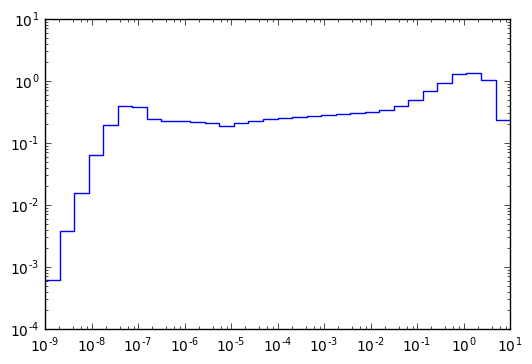

In [15]:
plt.loglog(*stair_step(f3.bins, np.array(t3.get_values().flat)))

In [16]:
ods = data_source.OpenMCDataSource('/home/robert/openmc/data/nndc/cross_sections.xml', f3.bins)

In [17]:
eg, fg = f3.bins, np.array(t3.get_values().flat)

In [18]:
ep, fp = ods.pointwise(922350000, 'fission', temp=TEMP)

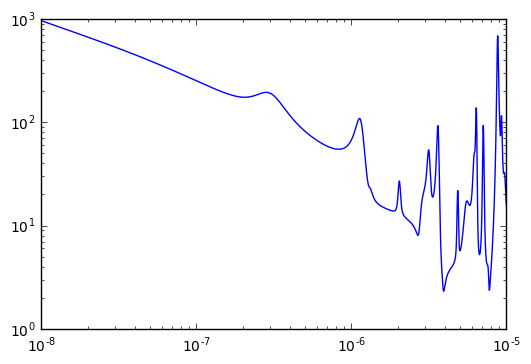

In [19]:
maskp = (1e-8 <= ep) & (ep <= 1e-5)
plt.loglog(ep[maskp], fp[maskp])

In [20]:
totxs = {}
for nuc in {'U235', 'U238', 'O16'}:
    totxs[nuc] = ods.pointwise(nuc, 'total', temp=TEMP)

In [21]:
mat = Material(mass=1, density=10.7)
mat.from_atom_frac({'U238': 0.97, 'U235': 0.03, 'O16': 2.0})

In [22]:
adens = mat.to_atom_dens()

In [23]:
sigb = (adens[922380000]*ods.reaction('U238', 'total', temp=TEMP) + \
        adens[80160000]*ods.reaction('O16', 'total', temp=TEMP)) / adens[922350000]

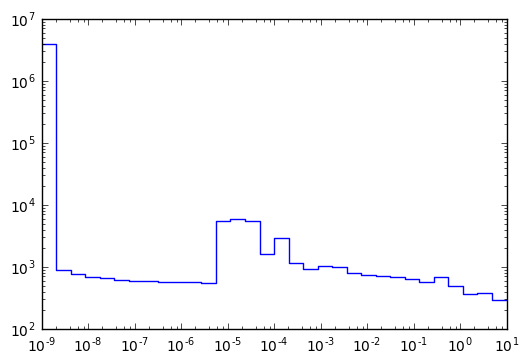

In [24]:
plt.loglog(*stair_step(ods.src_group_struct, sigb))

In [25]:
e_b = ods.src_group_struct
e_f, sig_f = ods.pointwise(922350000, 'fission', temp=TEMP)
e_t, sig_t = ods.pointwise(922350000, 'total', temp=TEMP)
sig_b = np.ones(len(e_f), 'f8')
for g in range(len(sigb)):
    sig_b[(e_b[g] <= e_t) & (e_t <= e_b[g+1])] = sigb[g]

In [26]:
denom = pointwise_linear_collapse(ods.src_group_struct, ep, 1.0/(e_t*(sig_b + sig_t)))

In [27]:
numer = pointwise_linear_collapse(ods.src_group_struct, ep, sig_f/(e_t*(sig_b + sig_t)))

In [28]:
ssxs = numer/denom

In [29]:
unssxs = ods.reaction('U235', 'fission', temp=TEMP)

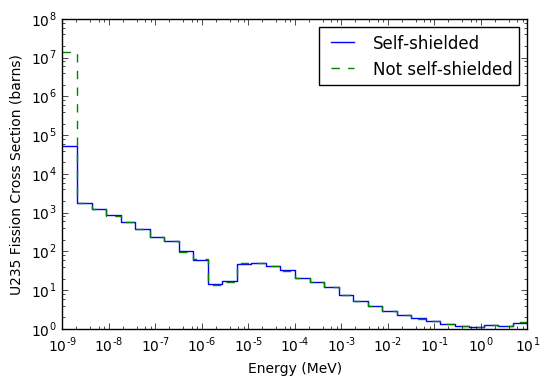

In [30]:
#maskp = (1e-8 <= e_f) & (e_f <= 1e-5)
#plt.loglog(e_f[maskp], sig_f[maskp])
#maskg = slice(3, -19)
maskg = slice(None)
plt.loglog(*stair_step(e_b[maskg], ssxs[maskg]), linestyle = "-", label='Self-shielded')
plt.loglog(*stair_step(e_b[maskg], unssxs[maskg]), linestyle = "--", label='Not self-shielded')
plt.xlabel("Energy (MeV)")
plt.ylabel("U235 Fission Cross Section (barns)")
plt.legend(loc=0)
plt.savefig("index.eps", format="eps")